In [1]:
%matplotlib inline
%load_ext Cython

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cython
from IPython.display import display_markdown
sns.set()

In [2]:
%%cython
cimport cython
cimport numpy as np
import numpy as np

@cython.boundscheck(False)
@cython.wraparound(False)
def list_of_sequence_length(np.ndarray a, slippy=True, aside=None):
    if aside is not None:
        aside = aside.values
    cdef int curi = 0
    cdef int i
    cdef int actu = -1
    out = []
    for i in range(len(a)):
        if actu != a[i] and (a[i] != 0 or not slippy):
            if curi > 0:
                out.append([val, curi])
            curi = 0
            actu = a[i]
            if aside is not None:
                val = aside[i]
            else:
                val = actu
        if a[i] == actu and a[i] != 0:
            curi += 1
    if curi != 0:
        out.append([val, curi])
    return out


def sequence_length(a, slippy=True, aside=None):
    return list_of_sequence_length(a.values, slippy, aside)



def sequence_length_mean(a, slippy=True, aside=None):
    elems = sequence_length(a, slippy, aside)
    if elems:
        return np.mean(elems)
    else:
        return np.NaN


# /data/logs/low-fake-2018-06-29-1018/fake_move/run_1/rep00//analysis_log_4999.txt

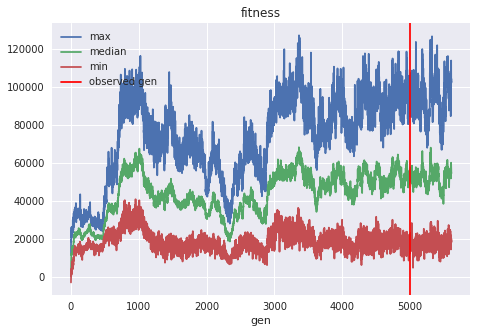

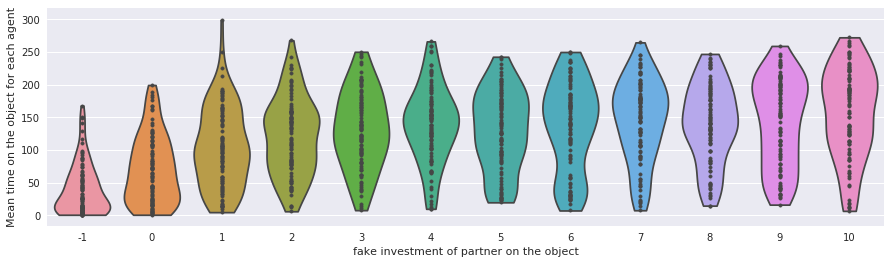

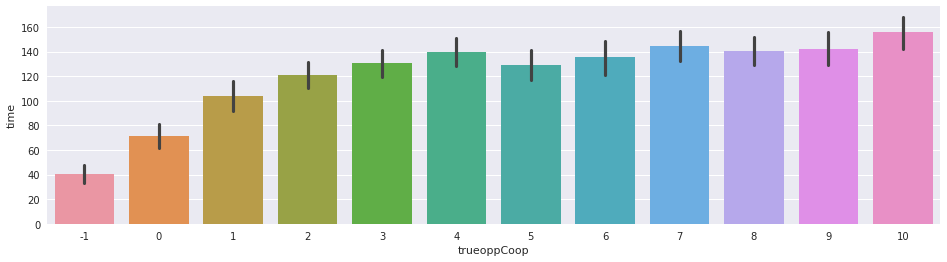

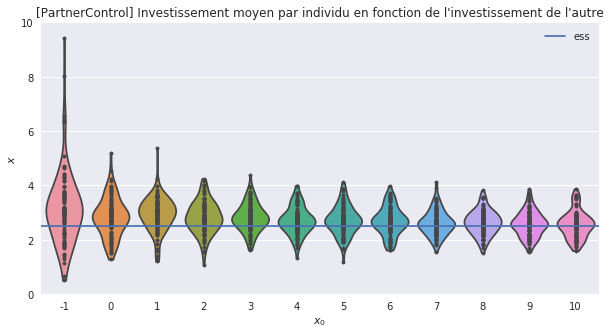

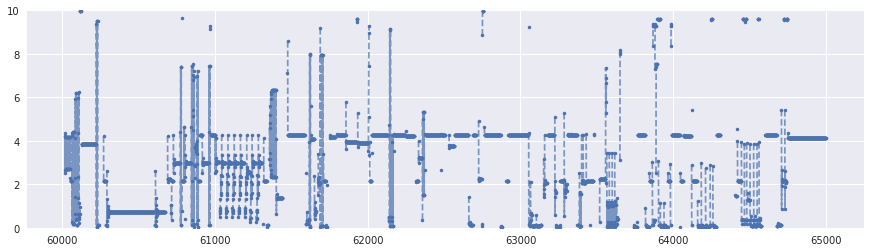

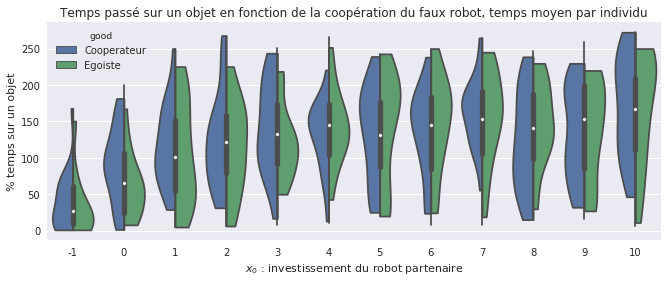

# /data/logs/low-fake-2018-06-29-1018/fake_move/run_2/rep00//analysis_log_4999.txt

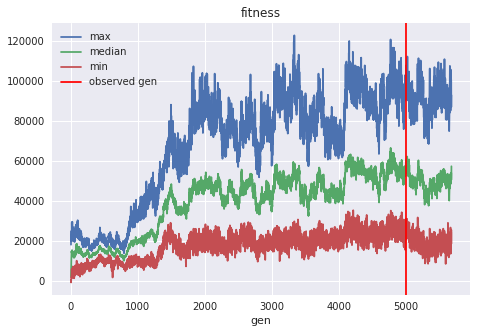

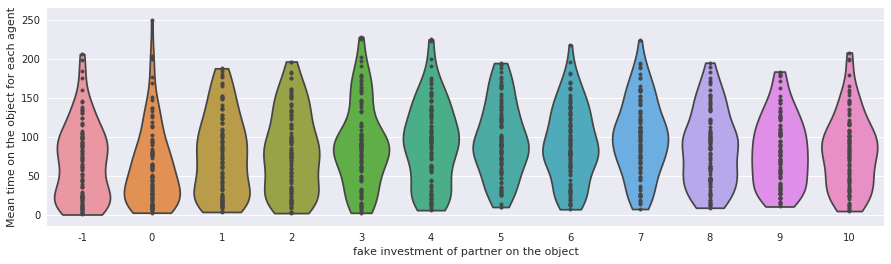

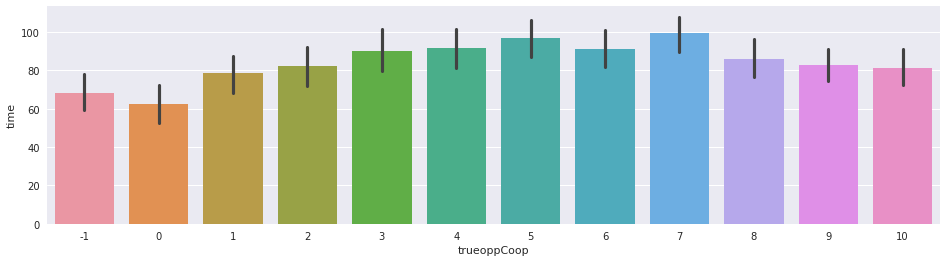

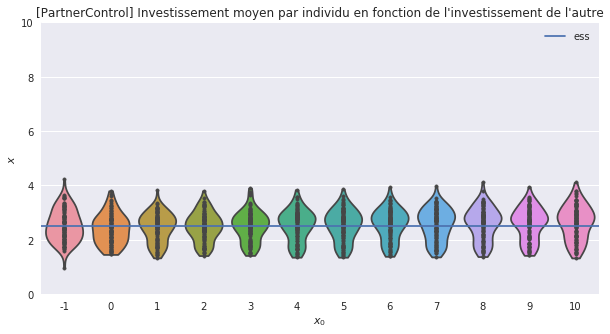

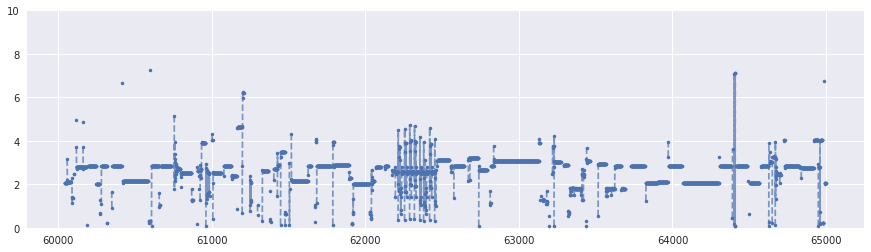

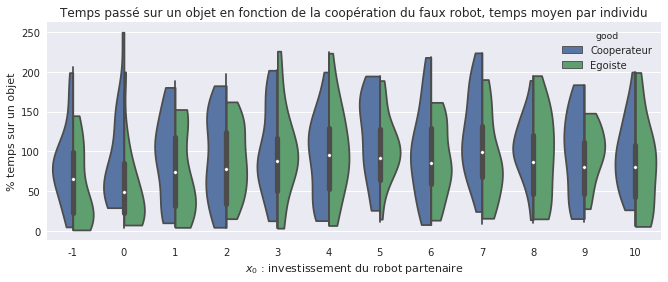

# /data/logs/low-fake-2018-06-29-1018/fake_move/run_3/rep00//analysis_log_4999.txt

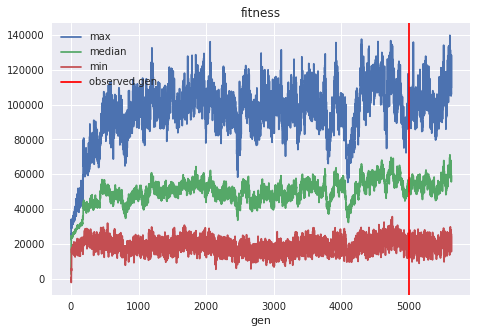

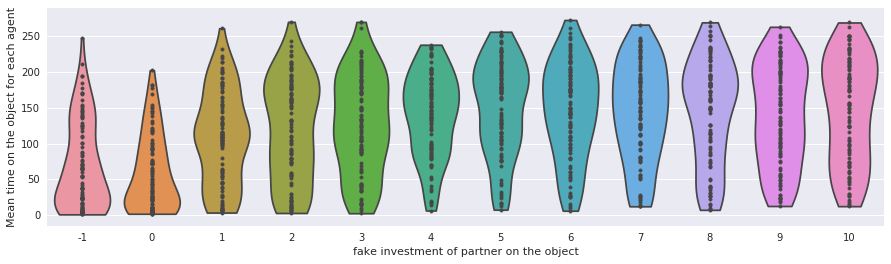

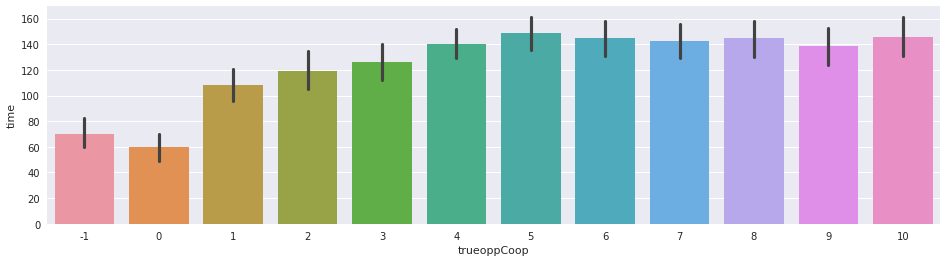

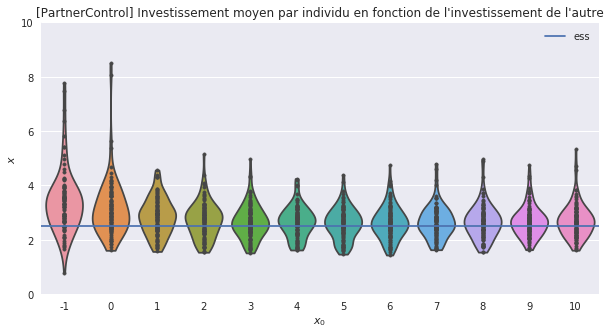

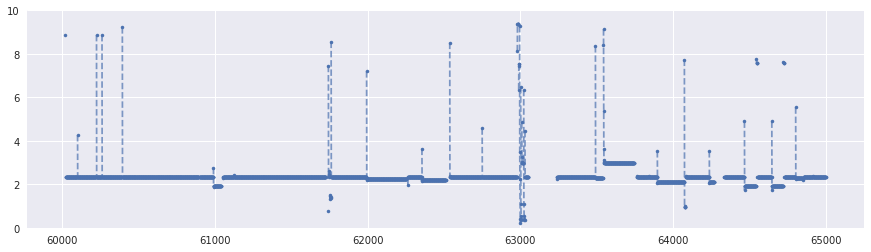

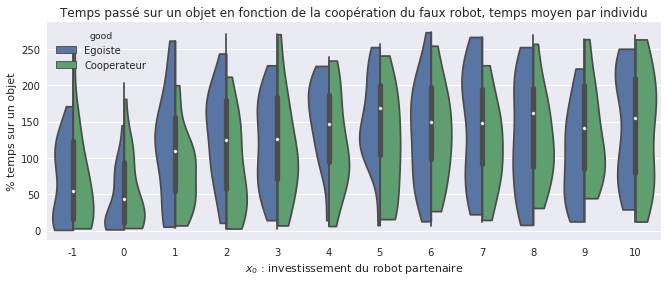

# /data/logs/low-fake-2018-06-29-1018/fake_move/run_4/rep00//analysis_log_4999.txt

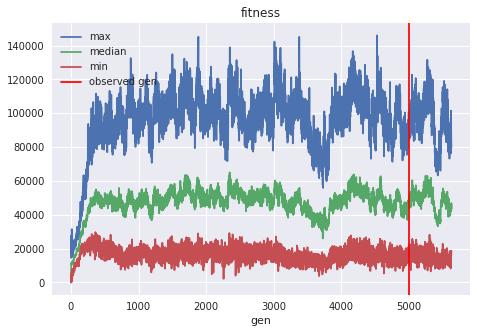

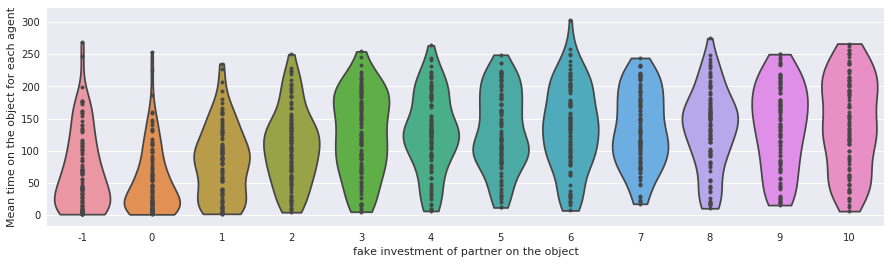

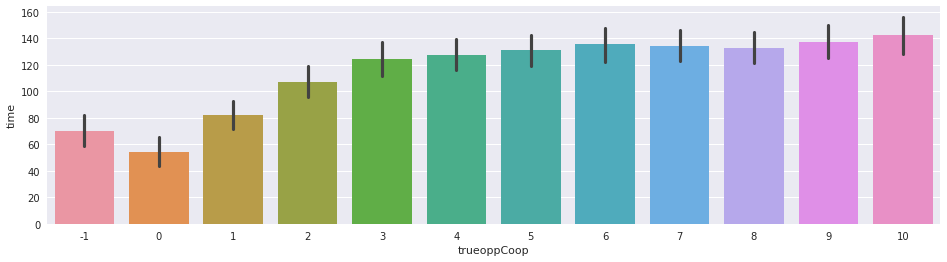

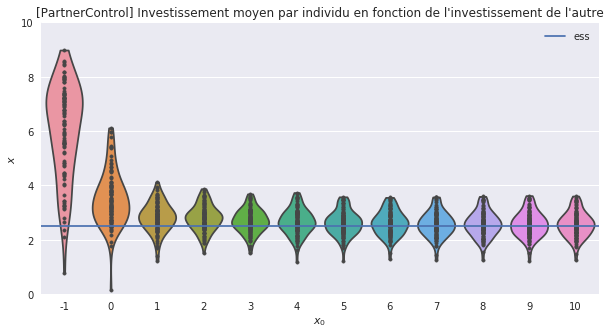

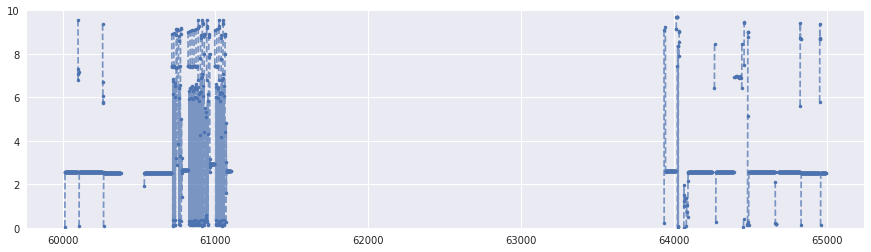

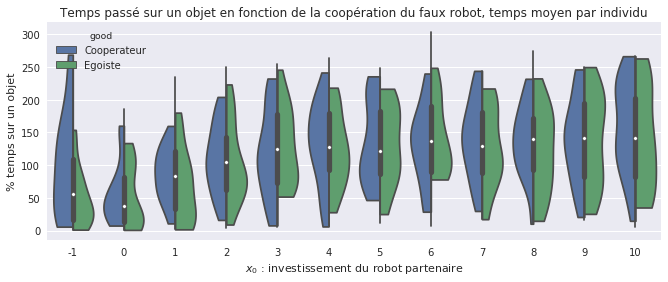

# /data/logs/low-fake-2018-06-29-1018/fake_move/run_5/rep00//analysis_log_4999.txt

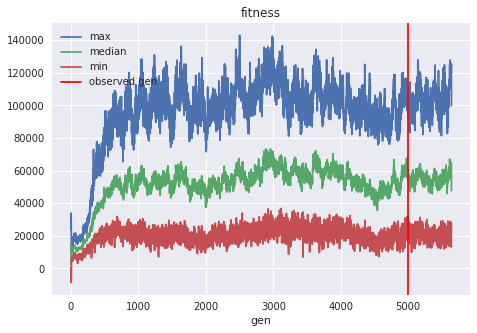

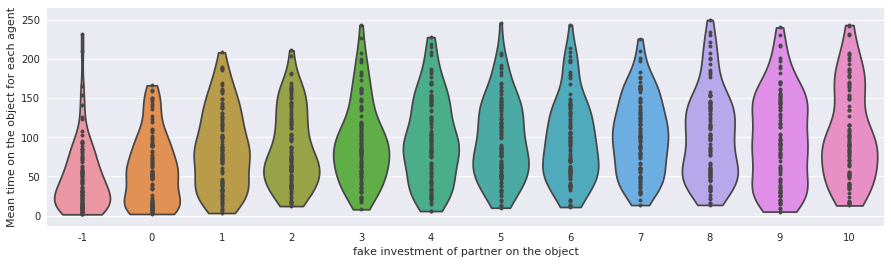

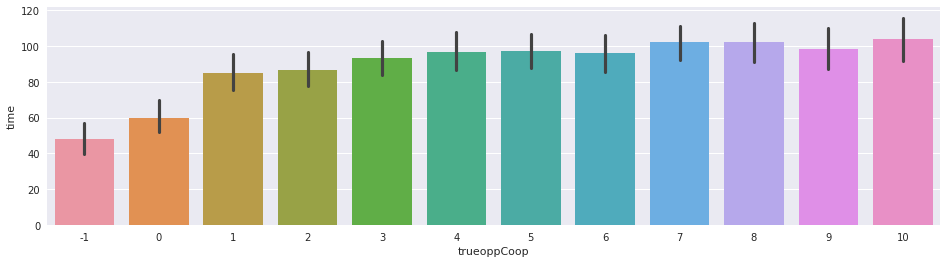

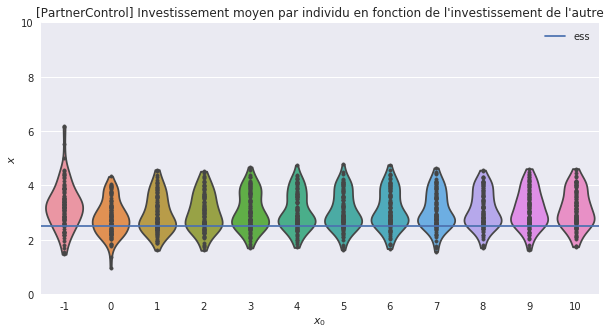

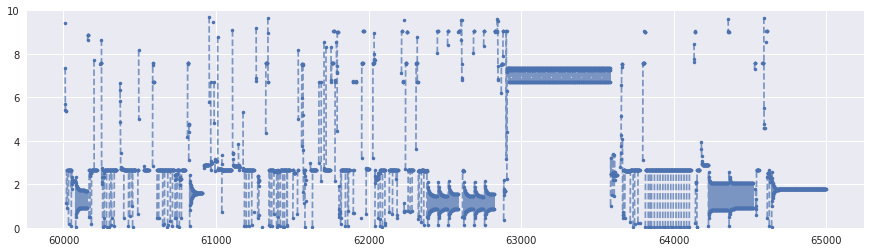

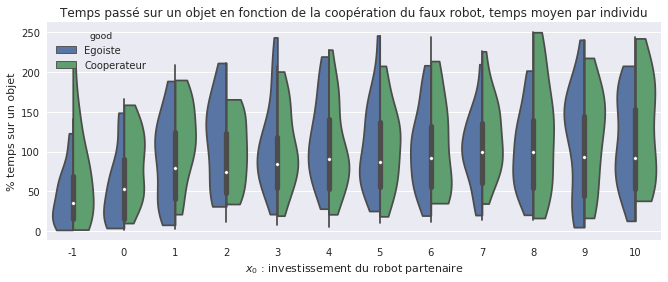

In [31]:
sns.set_context('notebook')
from itertools import product
for run, num in product(range(1, 6), [4999]):
    #path = f"/data/logs/tp-no-sensors-2018-06-28-2353/low_fake/run_{run}/rep00"
    path = f"/data/logs/low-fake-2018-06-29-1018/fake_move/run_{run}/rep00/"
    slippy = True
    if not slippy and not 'tp' in path : 
        print("Attention, activer slippy ?????")
    logpath = f"{path}/analysis_log_{num}.txt"
    display_markdown("# " + logpath, raw=True)

    fail = False
    fig, ax = plt.subplots(figsize=(5*1.5,5))

    try:
        fitpath = f"{path}/fitnesslog.txt"
        fit = pd.read_csv(fitpath, delimiter="\t")
        maxrep = fit['rep'].max()
        fit = fit.query(f'rep == {maxrep}')
    except pd.errors.EmptyDataError:
        fail = True
    except pd.errors.ParserError:
        fail = True
    else:
        fit.groupby('gen')['fitness'].max().plot(ax=ax, label='max')
        fit.groupby('gen')['fitness'].median().plot(ax=ax, label='median')
        fit.groupby('gen')['fitness'].min().plot(ax=ax, label='min')

    if fail:
        fitpath = f"{path}/../fit.txt"
        pd.read_csv(fitpath, delimiter="\t") 
        fit.groupby('gen')['fitness'].max().plot(ax=ax, label='max')
        fit.groupby('gen')['fitness'].median().plot(ax=ax, label='median')
        fit.groupby('gen')['fitness'].min().plot(ax=ax, label='min')


    ax.axvline(num, label="observed gen", color="red")
    ax.legend()
    ax.set_title('fitness')
    plt.show(fig)

    df = pd.read_csv(logpath, delimiter="\t")

    df['trueoppCoop'] = np.where((df['oppId'] > 0) & (df['oppNb'] == 0), -1, df['oppCoop'])
    df['onOpp'] = np.where(df['oppId'] > 0, 1, 0)

    timespent = df.groupby(['ind', 'rep']).apply(lambda x : pd.DataFrame(sequence_length(x['oppId'], slippy, x['trueoppCoop']), columns=['trueoppCoop', 'time'])).reset_index().infer_objects()
    timespent = timespent.groupby(['ind', 'trueoppCoop'], as_index=False).mean().copy()
    
    
    fig, ax = plt.subplots(figsize=(15, 4))
    sns.violinplot(data=timespent, x='trueoppCoop', y='time', cut=0, scale="width", inner="points", ax=ax)

    #plt.ylim(0,500)
    plt.ylabel('Mean time on the object for each agent')
    plt.xlabel('fake investment of partner on the object');
    #plt.ylabel('')
    #plt.xlabel('');
    plt.show(fig)
    fig.savefig('partnerchoice.svg')

    fig, ax = plt.subplots(figsize=(16, 4))
    sns.barplot(data=timespent, x='trueoppCoop', y='time', ax=ax)
    plt.show(fig)


    df['truecoop'] = np.where(df['onOpp'], df['ownCoop'], np.nan)
    #df['truecoop'][np.where(np.isnan(df['truecoop']))[0] + 1] = np.nan

    fig, ax = plt.subplots(figsize=(10, 5))
    sns.violinplot(data=df.query('onOpp > 0').groupby(['trueoppCoop', 'ind'], as_index=False).mean(), cut=0, x='trueoppCoop', y='ownCoop', scale='count', inner='points')
    ax.axhline(2.5, label='ess')
    ax.set_title("[PartnerControl] Investissement moyen par individu en fonction de l'investissement de l'autre")
    ax.legend()
    ax.set_ylabel("$x$")
    ax.set_xlabel("$x_0$")
    ax.set_ylim(0, 10);
    plt.show(fig)
    
    df['truecoop'] = np.where(df['onOpp'], df['ownCoop'], np.nan)

    fig, ax = plt.subplots(figsize=(15, 4))
    df.query('ind == 1 and rep == 2')['truecoop'].plot(ax=ax, style='.')
    df.query('ind == 1 and rep == 2')['truecoop'].plot(ax=ax, style='--', alpha=0.7, c=sns.palettes.get_color_cycle()[0])
    ax.set_ylim(0, 10)
    plt.show(fig)

    best = df.groupby('ind', as_index=False).mean()['truecoop'].nlargest(20).index
    worst = df.groupby('ind', as_index=False).mean()['truecoop'].nsmallest(20).index

    timespent.loc[np.where(timespent['ind'].isin(best))[0], 'good'] = 'Cooperateur'
    timespent.loc[np.where(timespent['ind'].isin(worst))[0], 'good'] = 'Egoiste'

    plt.figure(figsize=(11, 4))
    sns.violinplot(data=timespent, x='trueoppCoop', y='time', cut=0, scale='count', hue='good', split=True)
    plt.title("Temps passé sur un objet en fonction de la coopération du faux robot, temps moyen par individu")
    plt.ylabel("% temps sur un objet")
    plt.xlabel("$x_0$ : investissement du robot partenaire");
    plt.show()